## Predicting Customer Churn

Customer churn or attrition is the defined as the loss of customers for a business. As no business wants to lose customers, customer churn or attrition rate is often employed as a Key performance indicator (KPI) by many businesses to measure their performance. It also turns out in many companies that retaining customers is easier and cheaper than bringing in new ones. Therefore it makes sense for these companies to employ marketing strategies to retain existing customers and prevent them from churning. 

Churn prediction can go a long way in helping identify potential customers who might be prone to churning. With this information at hand companies can perform targeted marketing and offer suitable deals/benefits to retain these customers. In this analysis I will look at IBM's Telco customer churn data to analyse and predict customer churn using machine learning models. I will also perform a simple business impact analysis of the models to show how this information can actually be useful in a business context.

#### Reading and exploring the raw data

In [1]:
# Importing all the needed modules

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Importing scikit-learn modules
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score 
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, average_precision_score

import warnings
warnings.filterwarnings("ignore")

sns.set_palette("deep")
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
df = pd.read_csv('Telecom_Customer_Churn.csv')

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
df.shape

(7043, 21)

In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

### Data cleaning and manipulation

In [7]:
pd.DataFrame(dict(missing_values = df.isnull().sum(),unique_values = df.nunique()))

missing_values  unique_values
customerID                     0           7043
gender                         0              2
SeniorCitizen                  0              2
Partner                        0              2
Dependents                     0              2
tenure                         0             73
PhoneService                   0              2
MultipleLines                  0              3
InternetService                0              3
OnlineSecurity                 0              3
OnlineBackup                   0              3
DeviceProtection               0              3
TechSupport                    0              3
StreamingTV                    0              3
StreamingMovies                0              3
Contract                       0              3
PaperlessBilling               0              2
PaymentMethod                  0              4
MonthlyCharges                 0           1585
TotalCharges                   0           6531
Churn                          0              2

Based on this information I can see that there are no missing values in this dataset and all but `CutomerID`,`tenure`, `MonthlyCharges` and `TotalCharges` columns are categorical. I will now go ahead and convert these to the categorical type following which I will perform some data preprocessing before diving into EDA. 

In [8]:
telco_data = df.copy()

col_names = df.columns.tolist()
non_categorical_columns = ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

cat_col_names =[]

for col in col_names:
    if col not in non_categorical_columns:
        telco_data[col] = telco_data[col].astype('category')
        cat_col_names.append(col)
        
target_variable = 'Churn'

cat_col_names.remove('Churn')
col_names.remove('Churn')

I tried to convert `TotalCharges` column to float but got an error. Looking a bit more into the csv file, I find that there are some empty strings in the `TotalCharges` column, which I replace with NaNs and convert this column to the float type. 

In [9]:
telco_data['TotalCharges'] = telco_data['TotalCharges'].replace(" ", np.nan).astype(float)

In [10]:
telco_data['TotalCharges'].isnull().sum()

11

Since only 11 rows out of the 7043 (0.15%) contain missing values in only one column, one way top deal with this is to drop these rows. But we don't want to lose information from other columns for these rows so, another method would be to impute these values using some aggregate statistic. Here I will have a look at the distribution of the values in the `TotalCharges` column and try to figure out a suitable aggregate to impute the values.

(array([1881.,  828.,  687.,  541.,  368.,  303.,  263.,  245.,  223.,
         231.,  205.,  207.,  194.,  201.,  163.,  147.,  127.,   96.,
          83.,   39.]),
 array([  18.8,  452.1,  885.4, 1318.7, 1752. , 2185.3, 2618.6, 3051.9,
        3485.2, 3918.5, 4351.8, 4785.1, 5218.4, 5651.7, 6085. , 6518.3,
        6951.6, 7384.9, 7818.2, 8251.5, 8684.8]),
 <a list of 20 Patch objects>)

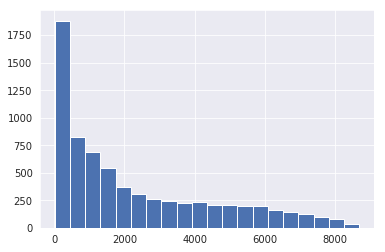

In [11]:
plt.hist(telco_data['TotalCharges'], bins=20)

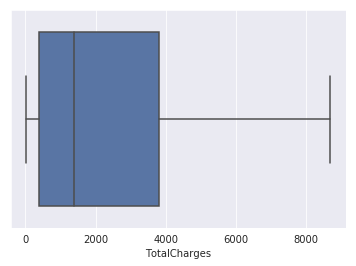

In [12]:
sns.boxplot(x=telco_data['TotalCharges'])

It appears that median is a good choice for replacing the missing values since there seems to be some right skewness in the data distribution.

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
telco_data['TotalCharges'] = imputer.fit_transform(telco_data[['TotalCharges']])

In [14]:
telco_data.describe()

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2281.916928
std      24.559481       30.090047   2265.270398
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000

#### Exploratory data analysis

After performing some data observation, cleaning and preprocessing I now go on to explore the data in more depth.

In [15]:
sns.countplot(x='Churn',data=telco_data)
plt.title('Number of churning customers in telco data')

Text(0.5, 1.0, 'Number of churning customers in telco data')

In [16]:
telco_data['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

It can be seen in the data that about $73.4\%$ of customers are not going to churn while about $26.5\%$ customers are looking to move. Since churn is our target variable, this is an example of unbalanced classes where one class has significantly more data than the other. I will have to deal with this problem using some techniques for unbalanced classes.

I now look at the Churn count in each individual variable by plotting the count plots of the variables. 

In [17]:
fig = plt.figure(figsize=(24, 20))
for i, col in enumerate(cat_col_names):
    ax = plt.subplot(6, 3, i+1)
    sns.countplot(x=col, hue='Churn', data=telco_data)    
    plt.title(col + ' churn count')
plt.tight_layout()

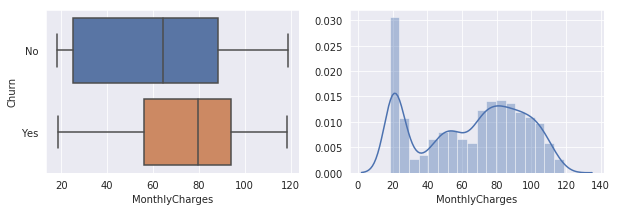

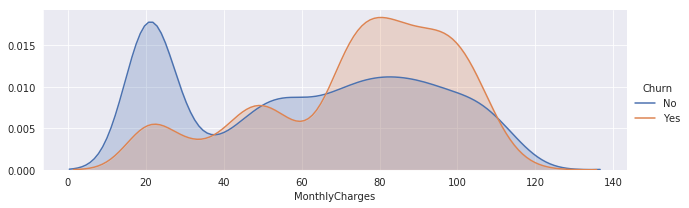

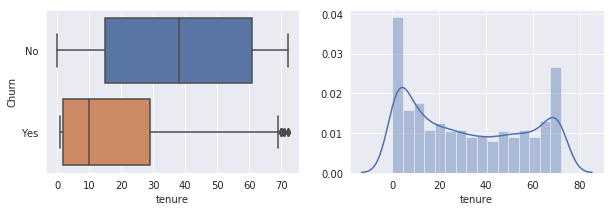

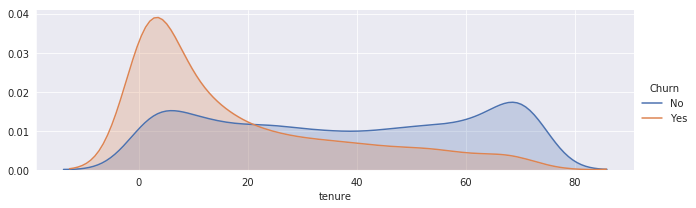

In [18]:
numerical_columns = ['MonthlyCharges', 'TotalCharges', 'tenure']
for i, col in enumerate(numerical_columns):       
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10, 3))    
    sns.boxplot(x=col, y='Churn', data=telco_data, ax=ax1)    
    sns.distplot(telco_data[col], ax=ax2)    
    sns.FacetGrid(telco_data, hue='Churn', height = 3, aspect =3).map(sns.kdeplot, col, shade=True).add_legend() 
    

#### Data Preprocessing

Before I begin any prediction, I will preprocess the data to make it suitable for use in the algorithms. I start by dropping the CustomerID column which is just a unique ID and does not offer any information about the data. After this I scale the numerical columns and encode the categorical columns using dummy variables.

In [19]:
X = telco_data[col_names].drop('customerID', axis=1)
y = telco_data['Churn']

In [20]:
scaler = StandardScaler()
scalar_X = pd.DataFrame(scaler.fit_transform(X[numerical_columns]), columns=numerical_columns)

dummy_X = pd.get_dummies(data = X, columns=cat_col_names, drop_first=True)
    

X = pd.merge(scalar_X, dummy_X.drop(numerical_columns, axis=1), left_index=True, right_index=True)
y = y.cat.codes

### Feature selection and handling class imbalance

Since the dataset has imbalanced classes, I first wanted to address this issue. Some ways to deal with this issue are over sampling, under sampling or creating new data for the under represented class. One way to create new instances is the `SMOTE` which stands for Synthetic Minority Over-sampling Technique. It creates new data points by convex combination of points which are close to each other. The scikit imabanced-learn package provides is an excellent package to deal with imbalanced data and we use the implementation of the SMOTE algorithm here. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y )
predictors = X_train.columns

In [22]:
smote = SMOTE()
smote_X, smote_y = smote.fit_sample(X_train, y_train)
X_train = pd.DataFrame(data=smote_X, columns=predictors)
y_train = pd.DataFrame(data=smote_y, columns=[target_variable])

y_train['Churn'].value_counts()

1    3622
0    3622
Name: Churn, dtype: int64

After the classes have been balanced, I now look at feature selection process in order to select the most appropriate features to build my machine learning models. One way to do this is using the domain knowledge of an expert. Since I am not an expert in the domain of telecommunication I will have to use other ways to gauge feature importance. Scikit learn provides feature importances as a by product when building different machine learning models. This is a techniue widely used to determine which features are the the most important when a particular model is built. 

- Logistic Regression with lasso


In [23]:
logit = LogisticRegression()
coef = logit.fit(X_train, y_train).coef_[0]

In [26]:
dictionary = {name:round(c, 4) for name, c in zip(predictors.tolist(), coef.tolist()) }
score_frame = pd.DataFrame.from_dict(dictionary, orient='index', columns=['score'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

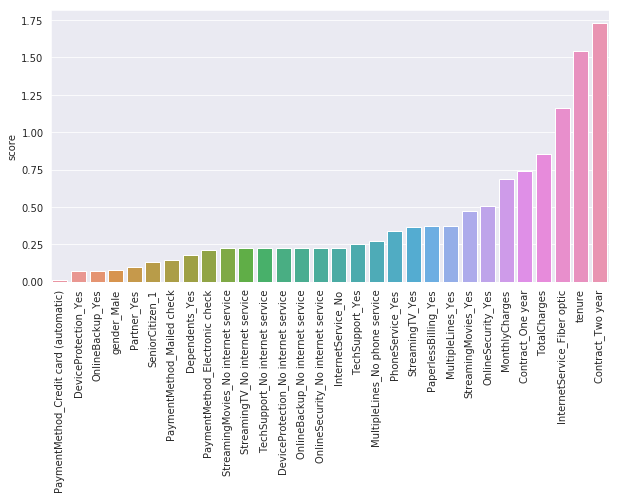

In [27]:
score_frame['score'] = a['score'].map(np.abs)
score_frame = score_frame.sort_values(by='score')
fig = plt.figure(figsize=(10,5))
sns.barplot(x = score_frame.index, y='score', data=score_frame)
plt.xticks(rotation=90)

I select the top 15 features from the lasso technique as it allows for not important features to have 0 coefficients. 

In [28]:
important_features = score_frame.iloc[-15:,:].index.tolist()

X_train = X_train[important_features]
X_test = X_test[important_features]

## Building classification models

After selecting features the next step in the process is to build classification models to predict customer churn. I will build a few classifiers using the selected features and compare their performance base on some common metrics of model performance.

In this project I will build the following classifiers:

1. Random Forest
2. KNN 
3. Logistic regression
4. SVC 

In [48]:
y_train.shape

(7244, 1)

In [49]:
X_train.shape

(7244, 30)

In [71]:
rf_param_grid = {
    "clf__max_features": range(2, 7),
    "clf__min_samples_split": range(4, 10),
    "clf__min_samples_leaf": range(1, 6),
    
}

# Creating imbalanced learn pipeline for proper handling of SMOTE data in GridSearch

rf_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', RandomForestClassifier(
    n_estimators=20, criterion="entropy", random_state=42))
    ])

# Grid search over parameter space
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
 ...mators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__max_features': range(2, 7), 'clf__min_samples_split': range(4, 10), 'clf__min_samples_leaf': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [73]:
rf_best = rf_grid.best_estimator_

In [55]:
knn_param_grid = {'clf__n_neighbors':[4, 8, 16], 'clf__weights': ['uniform', 'distance']}

knn_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', KNeighborsClassifier())
    ])

knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, scoring='f1', n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   37.1s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__n_neighbors': [4, 8, 16], 'clf__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [56]:
knn_best = knn_grid.best_estimator_

In [57]:
logit_params = {'clf__penalty': ['l1', 'l2'], 'clf__C':0.001 * 10**(np.arange(0, 1.01, 0.01) * 3)}

logit_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', LogisticRegression())
    ])

logit_grid = GridSearchCV(logit_pipeline, logit_params, n_jobs=-1, verbose=1)
logit_grid.fit(X_train, y_train)

Fitting 3 folds for each of 202 candidates, totalling 606 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 591 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 606 out of 606 | elapsed:   22.9s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf', LogisticRegression(C=1.0, class_weight=None...enalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__penalty': ['l1', 'l2'], 'clf__C': array([0.001  , 0.00107, ..., 0.93325, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [58]:
logit_best = logit_grid.best_estimator_

In [63]:
svc_params = {'clf__kernel' : ['rbf'], 'clf__gamma' : [0.01, 0.1, 1], 'clf__C' : [10, 50 ,100, 200]}

svc_pipeline = Pipeline([
        ('sampling', SMOTE()),
        ('clf', SVC(probability=True))
    ])

svc_grid = GridSearchCV(svc_pipeline, svc_params, scoring='f1', n_jobs=-1, verbose=True)
svc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__kernel': ['rbf'], 'clf__gamma': [0.01, 0.1, 1], 'clf__C': [10, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=True)

In [64]:
svc_best = svc_grid.best_estimator_

### Evaluating the performance of the classifiers

In [81]:
metrics = ['classifier', 'accuracy', 'precision', 'recall', 'f1-score', 'roc_aur', 'avg_precision']

models_performance = pd.DataFrame(columns=metrics)
conf_matrix = dict()
roc_auc = dict()
precision_recall = dict()

I wrote a general function which will accept the classifier and the grid search values and report the best grid parameters. It also computes some metrics for performance and saves them to a dataframe. Finally it also saves the roc curve, confusion matrix and precision recall curve values in respective dictionaries. I can call this function for each classifier and this will populate the dictionaries of metrics which can then be used to plot them.

In [74]:
def performance_measure(name, classifier, grid):
    print('Best score in grid:', grid.best_score_)
    print('best parameters in grid\n:', grid.best_params_)
    
    predictions = classifier.predict(X_test)
    probabilities = classifier.predict_proba(X_test)[:,-1]
    models_performance.loc[len(models_performance)] = [
        name,
        accuracy_score(y_test, predictions),
        precision_score(y_test, predictions),
        recall_score(y_test, predictions),
        f1_score(y_test, predictions),
        roc_auc_score(y_test, predictions),
        average_precision_score(y_test, predictions)
    ]
    
    conf_matrix[name] = confusion_matrix(y_test, predictions)
    fpr, tpr, thresh = roc_curve(y_test, probabilities)    
    roc_auc[name] = (fpr, tpr, thresh, predictions, probabilities)
    p, r, threshold = precision_recall_curve(y_test, probabilities)
    precision_recall[name] = (p, r, threshold, predictions, probabilities)    

In [82]:
performance_measure('SVC', svc_best, svc_grid)

Best score in grid: 0.8860460428754371
best parameters in grid
: {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}


In [83]:
performance_measure('Random Forest', rf_best, rf_grid)

Best score in grid: 0.8382548893779976
best parameters in grid
: {'clf__max_features': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4}


In [84]:
performance_measure('KNN', knn_best, knn_grid)

Best score in grid: 0.8417986163025509
best parameters in grid
: {'clf__n_neighbors': 4, 'clf__weights': 'distance'}


In [85]:
performance_measure('Logistic Reg', logit_best, logit_grid)

Best score in grid: 0.7722252898950855
best parameters in grid
: {'clf__C': 0.6165950018614822, 'clf__penalty': 'l2'}


In [86]:
models_performance

classifier  accuracy  precision    recall  f1-score   roc_aur  \
0            SVC  0.751538   0.538793  0.445633  0.487805  0.653873   
1  Random Forest  0.776148   0.582090  0.556150  0.568824  0.705910   
2            KNN  0.691907   0.444444  0.641711  0.525164  0.675881   
3   Logistic Reg  0.748699   0.517241  0.802139  0.628931  0.765760   

   avg_precision  
0       0.387288  
1       0.441571  
2       0.380330  
3       0.467431

In [87]:
fig = plt.figure(figsize=(15, 8))
temp = models_performance.melt('classifier', var_name='cols', value_name='vals')
sns.barplot(data=temp,x='classifier', y='vals', hue='cols')

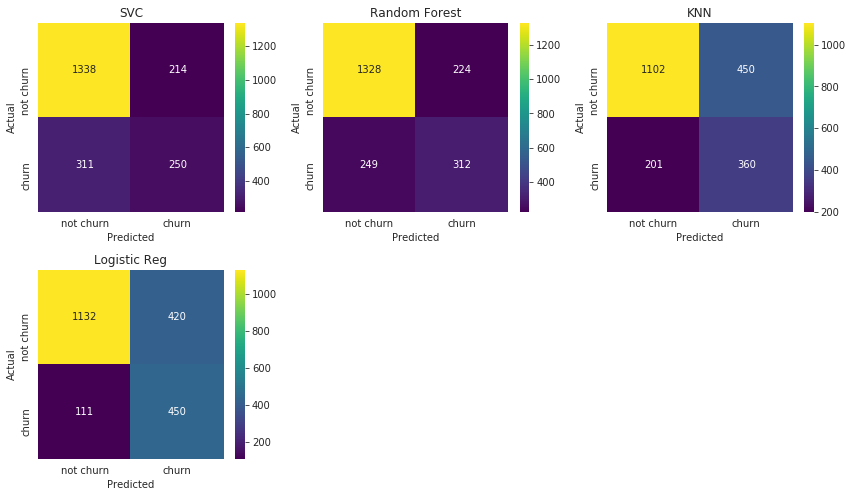

In [88]:
fig = plt.figure(figsize=(12, 10))
for i, (classifier, matrix) in enumerate(conf_matrix.items()):
        plt.subplot(3, 3, i+1)
        class_names = ['Not churn', 'Churn']
        sns.heatmap(matrix, 
                    annot=True,
                    xticklabels=["not churn", "churn"],
                    yticklabels=["not churn", "churn"],
                    fmt='d',
                    cmap='viridis'
                   )
        plt.title(classifier)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
plt.tight_layout()        


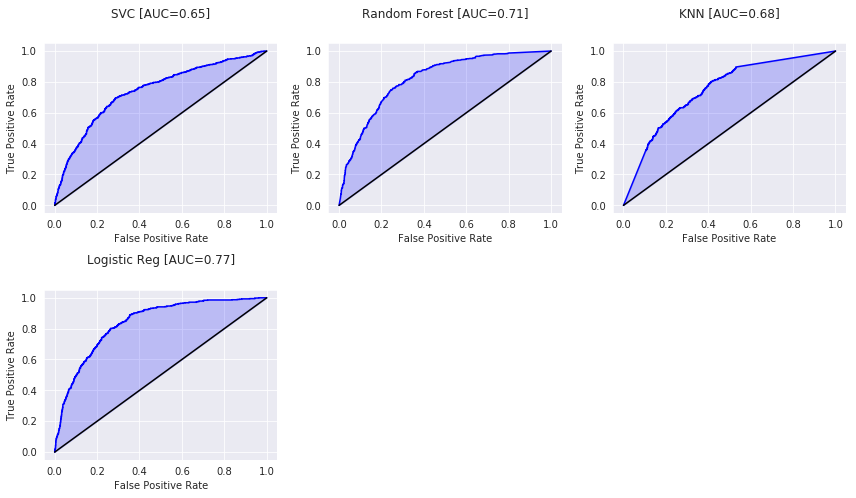

In [89]:
fig = plt.figure(figsize=(12, 10))
for i, (classifier, roc) in enumerate(roc_auc.items()):
    plt.subplot(3, 3, i+1)
    fpr, tpr, threshold, predict, proba = roc    
    plt.plot(fpr, tpr, color='blue')
    plt.plot(fpr, fpr, color='black')
    plt.fill_between(fpr, tpr, fpr, color='blue', alpha='0.2')
    auc = models_performance.loc[models_performance['classifier'] ==
                                   classifier, 'roc_aur']
    plt.title(
        classifier + ' [AUC=' + str(np.round(auc.values[0], 2)) + ']',
        y=1.12)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plt.tight_layout()


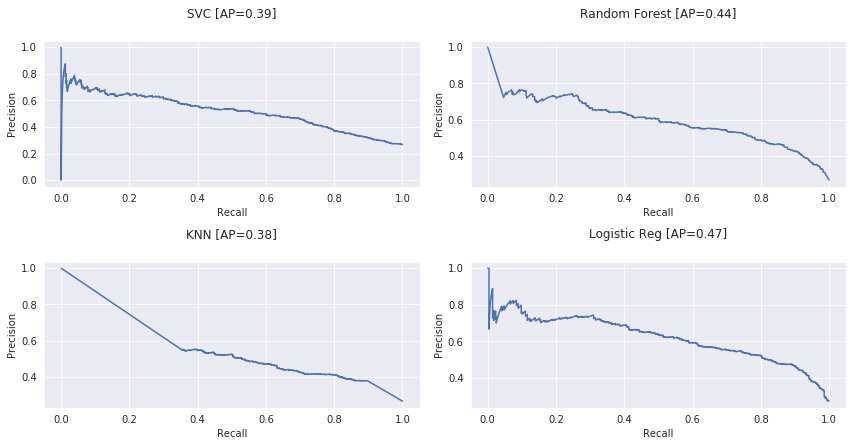

In [90]:
fig = plt.figure(figsize=(12, 12))
for i, (classifier, pr_items) in enumerate(precision_recall.items()):
    p, r, threshold, pred, prob = pr_items
    plt.subplot(4, 2, i + 1)
    plt.plot(r, p)
    auc = models_performance.loc[models_performance['classifier'] ==
                                   classifier, 'avg_precision']
    plt.title(
        classifier + ' [AP=' + str(np.round(auc.values[0], 2)) + ']',
        y=1.12)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
plt.tight_layout()

Finally, in order to select the model with the best predictions, I concatenate the predictions of all the models and plot a heatmap.

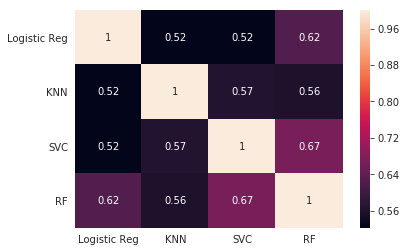

In [91]:
final_df = pd.DataFrame({ 
             'Logistic Reg': logit_best.predict(X_test), 
             'KNN':knn_best.predict(X_test), 
             'SVC':svc_best.predict(X_test), 
             'RF': rf_best.predict(X_test)})

sns.heatmap(final_df.corr(), annot=True)

## Business context

We have trained some classifiers and evaluated their performance. How is this information useful in a business context. How can we use what we have learnt to retain customers and remain profitable as a business. 

Based on the precision and recall values of the model for different values of thresholds we can see that changing the threshold can lead to different values in these metrics. In a business setting if somehow we can set a threshold value so that we can maximise our profit/minimise our losses, based on certain business assumptions or requirements then we can tailor our model according to our needs.

I will show this with a simple example scenario:
1. Let us assume that if a customer churns we lose a value of 1.
2. If a customer takes a reward we offer and stays with us we lose 0.1.
3. If a customer stays and does not take reward we lose 0.

Also I will base my analysis on two assumptions:
1. `50%` customers take the reward and stay.
2. All the customers who were not going to churn will take the reward.

I will now try to show how the loss changes with different values of threshold.

In [92]:
# Let us select a particular classifier for this analysis: SVC
name = 'SVC'
threshold_scv = precision_recall[name][2]
y_prob = precision_recall[name][4]
y_pred = precision_recall[name][3]

accuracy = np.zeros(threshold_scv.shape)
precision = np.zeros(threshold_scv.shape)
recall = np.zeros(threshold_scv.shape)
true_positives = np.zeros(threshold_scv.shape)
false_positives = np.zeros(threshold_scv.shape)
false_negatives = np.zeros(threshold_scv.shape)

for i in range(0,threshold_scv.shape[0]):    
    accuracy[i] = accuracy_score(y_test, y_prob >= threshold_scv[i])
    precision[i] = precision_score(y_test, y_prob >= threshold_scv[i])
    recall[i] =  recall_score(y_test, y_prob >= threshold_scv[i])
    confusion_ = confusion_matrix(y_test, y_prob >= threshold_scv[i])
    true_positives[i] = confusion_[1][1]
    false_positives[i] = confusion_[0][1]
    false_negatives[i] = confusion_[1][0]

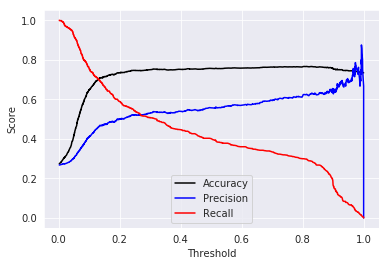

In [93]:
fig = plt.figure()
plt.plot(threshold_scv, accuracy, color='k', label='Accuracy')
plt.plot(threshold_scv, precision, color='b', label='Precision')
plt.plot(threshold_scv, recall, color='r', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc="lower center");

In [94]:
# probability that a customer who would churn accepts reward = 50%
prob_reward_accept = 0.5
loss = true_positives * prob_reward_accept * (-0.1) + true_positives * (1 - prob_reward_accept) * (-1) + false_negatives * (-1) + false_positives * (-0.1)

optim_threshold = threshold_scv[loss == max(loss)][0]

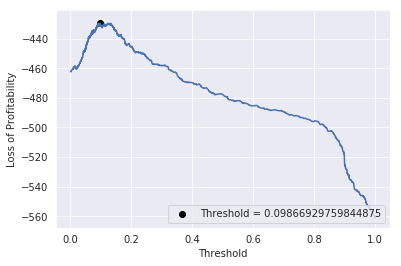

In [95]:
fig = plt.figure()
plt.plot(threshold_scv, loss)
plt.scatter([optim_threshold], [max(loss)], color='black', label=f'Threshold = {optim_threshold}')
plt.xlabel('Threshold')
plt.ylabel('Loss of Profitability')
plt.legend(loc="lower right")

Finally I will create the confusion matrix for the model with the optimal threshold.

In [2]:
y_preds_new = y_prob > optim_threshold
c_matrix_optim = confusion_matrix(y_test, y_preds_new)

fig = plt.figure()
sns.heatmap(c_matrix_optim, annot=True, fmt='d', xticklabels=['churn', 'not churn'], yticklabels=['churn', 'not churn'])

NameError: name 'y_prob' is not defined

In [1]:
c_matrix_optim

NameError: name 'c_matrix_optim' is not defined